In [ ]:
datContent = [i.strip().split() for i in open("./ml-10M100K/ratings.dat").readlines()]

In [ ]:
print(datContent[1])
userIds, movieIds, ratings, timestamps = [], [], [], []
for line in datContent:
    userId, movieId, rating, timestamp = line[0].split("::")
    userIds.append(userId)
    movieIds.append(movieId)
    ratings.append(rating)
    timestamps.append(timestamp)
data = {'userId':  userIds,
        'movieId': movieIds,
        'rating': ratings,
        'timestamp': timestamps
        }

df = pd.DataFrame (data, columns = ['userId','movieId', 'rating', 'timestamp'])
df.head()


['1::185::5::838983525']


,userId,movieId,rating,timestamp
0,1,122,5,838985046
1,1,185,5,838983525
2,1,231,5,838983392
3,1,292,5,838983421
4,1,316,5,838983392


In [ ]:
df.to_csv ('./ml-10M100K/ratings.csv', index = False, header=True)

#**0. Start**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive/

/content/drive/MyDrive


In [ ]:
# !wget  http://files.grouplens.org/datasets/movielens/ml-25m.zip
# !unzip ml-25m.zip
# !wget  http://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip
# !wget  http://files.grouplens.org/datasets/movielens/ml-20m.zip
# !unzip ml-20m.zip
# !wget  http://files.grouplens.org/datasets/movielens/ml-10m.zip
# !unzip ml-10m.zip

In [ ]:
import os
import shutil
import sys
import time
import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
import pandas as pd
from sklearn.metrics import ndcg_score

In [ ]:
import bottleneck as bn
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

In [ ]:
#-------------------------
def human_format(num):
    magnitude=0
    while abs(num)>=1000:
        magnitude+=1
        num/=1000.0
    return '%.1f%s'%(num,['','K','M','G','T','P'][magnitude])

def print_model_report(model):
    print('-'*100)
    print(model)
    print('Dimensions =',end=' ')
    count=0
    for p in model.parameters():
        print(p.size(),end=' ')
        count+=np.prod(p.size())
    print()
    print('Num parameters = %s'%(human_format(count)))
    print('-'*100)
    return count

#-------------------------
def print_optimizer_config(optim):
    if optim is None:
        print(optim)
    else:
        print(optim,'=',end=' ')
        opt=optim.param_groups[0]
        for n in opt.keys():
            if not n.startswith('param'):
                print(n+':',opt[n],end=', ')
        print()
    return

#-------------------------------
def get_model(model):
    return deepcopy(model.state_dict())

def set_model_(model,state_dict):
    model.load_state_dict(deepcopy(state_dict))
    return

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return
#-------------------------------
def log_gauss(var, mu ,sig, rho=True):
    log2_pi = torch.Tensor([np.log(2*np.pi)]).cuda()
    if(rho):
        sig = torch.log1p(torch.exp(sig))
  
    return  -0.5*log2_pi - torch.log(sig) - 0.5* ((var - mu)**2 / sig**2)

def log_prior_w(w, Pi= 0.5, sigma1= 1, sigma2= np.exp(-6), gmm = True):
    if gmm:
        sig1 = torch.Tensor(w.shape).uniform_(sigma1,sigma1).cuda()
        sig2 = torch.Tensor(w.shape).uniform_(sigma2,sigma2).cuda()
        mu = torch.Tensor(w.shape).uniform_(0,0).cuda()
        gau1 = log_gauss(w,mu,sig1, rho= False) + np.log(Pi)
        gau2 = log_gauss(w,mu,sig2, rho= False) + np.log(1-Pi)
    
        # p = torch.log(Pi*torch.exp(log_gauss(w,mu,sig1, rho= False)) + (1-Pi)*torch.exp(log_gauss(w,mu,sig2, rho= False)))
        gau = torch.cat([gau1.unsqueeze(0),gau2.unsqueeze(0)], 0)  
        p = torch.logsumexp(gau,dim=0)
   
    else:
        log2_pi = torch.Tensor([np.log(2*np.pi)]).cuda()
        p = -0.5*log2_pi - 0.5*(w**2)
        
    return p


# **1. Data preparation**

In [ ]:
DATA_DIR = 'ml-25m'

In [ ]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), header=0)

##1.1. Keep data

In [ ]:
# binarize the data (only keep ratings > 3.5)
raw_data = raw_data[raw_data['rating'] > 3.5]

In [ ]:
raw_data.head()

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [ ]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=True)
    count = playcount_groupbyid.size()
    return count

In [ ]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

In [ ]:
# Đầu vào là tp (DataFrame), min_uc, min_sc
# Đầu ra: raw_data mới :
#             chỉ lấy những movieID có tổng số lượng đánh giá >= min_sc
#             chỉ lấy những userID đánh giá ít nhất min_uc bộ phim
#         user_activity: DataFrame chứa tổng số lượng phim được đánh giá
#         item_popularity: DataFrame chứa tổng số lượng lượt đánh giá từ userID
raw_data, user_activity, item_popularity = filter_triplets(raw_data, min_uc= 5, min_sc= 0)

In [ ]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 12448242 watching events from 160776 users and 40857 movies (sparsity: 0.190%)


##1.2. Split train-valid-test

In [ ]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()
    np.random.seed(98765)
    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group) # số lượng đánh giá của các user
        # nếu số lượng đánh giá <5 nhỏ , group được đưa vào training và không cho vào test(test_prop=0.2, 0.2*5 =1)
        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            # chọn ra các đánh giá của user làm test (test_prop * n_items_u), còn lại là train. 
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True
            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
            return
        else:
            tr_list.append(group)
        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [ ]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size) # method returns a re-arranged array (and leaves the original array un-changed)
unique_uid = unique_uid[idx_perm] # xếp lại danh sách user theo idx_perm vừa thực hiện 

In [ ]:
# create train/validation/test users
n_users = unique_uid.size
# n_heldout_users = 10000 #20m
# n_heldout_users = 500 #1m
# n_heldout_users = 5000 #10m
n_heldout_users = 15000 #25m
tr_users = unique_uid[:(n_users - n_heldout_users * 2)] # users for training
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)] # validation
te_users = unique_uid[(n_users - n_heldout_users):] # test

In [ ]:
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)] # tạo traning data từ tr_users được chọn 

In [ ]:
unique_sid = pd.unique(train_plays['movieId']) # các movieID tập tranning

In [ ]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid)) # (idx, moviedID)
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid)) # (idx, userID)

In [ ]:
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [ ]:
# validation : userID thuoc vd_users, movieID thuoc unique_sid (movieID trong training)
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [ ]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

      userId  movieId  rating   timestamp
0          1      296     5.0  1147880044
2          1      307     5.0  1147868828
3          1      665     5.0  1147878820
5          1     1088     4.0  1147868495
8          1     1237     5.0  1147868839
9          1     1250     4.0  1147868414
11         1     1653     4.0  1147868097
16         1     2351     4.5  1147877957
17         1     2573     4.0  1147878923
18         1     2632     5.0  1147878248
19         1     2692     5.0  1147869100
20         1     2843     4.5  1147868891
21         1     3448     4.0  1147868480
22         1     3569     5.0  1147879603
23         1     3949     5.0  1147868678
24         1     4144     5.0  1147868898
26         1     4325     5.0  1147878122
28         1     4703     4.0  1147869223
29         1     4973     4.5  1147869080
30         1     5147     4.0  1147877654
33         1     5767     5.0  1147878729
34         1     5878     4.0  1147868807
36         1     5952     4.0  114

TypeError: ignored

In [ ]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [ ]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled
14000 users sampled


##1.3. Save the data into (user_index, item_index) format

In [ ]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [ ]:
# print(profile2id)
# print(show2id)
# print(train_plays)
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [ ]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [ ]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [ ]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [ ]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

# **2. Evaluate**

In [ ]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk] * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(int(n), k)]).sum() for n in heldout_batch.sum(axis=1)])
    return DCG / IDCG

def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1) # top k
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0)
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

# **3. Approach**

In [ ]:
class Appr(object):    
    def __init__(self, model, optim= 'Adam', nepochs=100, train_batch=256, valid_batch= 2000, lr=0.001, anneal_cap= 0.2, total_anneal_steps= 200000, k_ndcg= 100,
                 lr_min=1e-7, lr_factor=3, lr_patience=5):

        
        self.ndcgs_vad = []

        self.optim = optim
        self.model = model
        self.nepochs = nepochs
        self.train_batch = train_batch
        self.valid_batch = valid_batch
        self.lr = lr
        self.anneal_cap= anneal_cap
        self.total_anneal_steps= total_anneal_steps
        self.k_ndcg = k_ndcg
        self.step = 0.0
        self.best_anneal = 1.
        self.anneal = 1.

        self.lr_min = lr_min
        self.lr_factor = lr_factor
        self.lr_patience = lr_patience
      
        self.epoch = 0
        
        self.param_name = []
        
        for (name, p) in self.model.named_parameters():
            self.param_name.append(name)
        
        self.optimizer = self._get_optimizer()
        return

    def _get_optimizer(self, lr=None):
        if lr is None: lr = self.lr
        if self.optim == 'Adam':
            return torch.optim.Adam(self.model.parameters(), lr=lr)
        if self.optim  == 'SGD':
            return torch.optim.SGD(self.model.parameters(),lr=lr)
    
    def train(self, xtrain, xvalid_tr, xvalid_te):
        print("TRAINING...")
        best_ndcg = -np.inf
        best_loss = np.inf
        best_model = get_model(self.model)
        lr = self.lr
        patience = self.lr_patience
        self.optimizer = self._get_optimizer(lr)

        nepochs = self.nepochs
        # Loop epochs
        for e in range(nepochs):
            self.epoch = self.epoch + 1
            # Train
            clock0 = time.time()
            self.train_epoch(xtrain)
            clock1 = time.time()
       
            ndcg_valid = self.eval(xvalid_tr, xvalid_te, k= self.k_ndcg)
            clock2 = time.time()
            print(' Epoch {:3d}, time={:5.1f}s/{:5.1f}s | Valid: ndcg_valid= {:.3f}% |'.format(e+1, clock1- clock0, clock2 - clock1, ndcg_valid),end='')

            if best_ndcg < ndcg_valid:
                best_model = get_model(self.model)
                best_ndcg = ndcg_valid
                self.best_anneal = self.anneal
            # if valid_loss < best_loss:
            #     best_loss = valid_loss
            #     patience = self.lr_patience
                print(' *', end='')
            # else:
            #     patience -= 1
            #     if patience <= 0:
            #         lr /= self.lr_factor
            #         lr_rho /= self.lr_factor
            #         print(' lr={:.1e}'.format(lr), end='')
            #         if lr < self.lr_min:
            #             print()
            #         patience = self.lr_patience
            #         self.optimizer = self._get_optimizer(lr)
            print()
            print(self.step, self.anneal)

                    
        # Restore best
        set_model_(self.model, best_model)

        return

    def train_epoch(self,x):
        no_sample = 2
        self.model.train()

        r = np.arange(x.shape[0])
        np.random.shuffle(r)

        sbatch = self.train_batch
        # Loop batches
        for i in range(0, len(r), sbatch):
            if i + sbatch <= len(r):
                b = r[i: i + sbatch]
            else:
                b = r[i:]
            
            train_data = x[b]
            if sparse.isspmatrix(train_data):
                train_data = train_data.toarray()
            train_data = torch.from_numpy(train_data.astype('float32')).cuda()
  
            if self.total_anneal_steps > 0:
                anneal = min(self.anneal_cap, 1. * self.step / self.total_anneal_steps)
                self.anneal = anneal
            else:
                anneal = self.anneal_cap
                self.anneal = anneal
            loss = 0
            for i in range(no_sample):
              loss += self.model.loss_forward(train_data, anneal)
            loss = loss/ no_sample
            # print(loss)
            # Backward
            self.optimizer.zero_grad()
            loss.backward()
            if self.optim == 'SGD' or self.optim == 'SGD_momentum_decay':
                torch.nn.utils.clip_grad_norm(self.model.parameters(),self.clipgrad)
            self.optimizer.step()
            
            self.step += 1
        return

    def eval(self, v_tr, v_te, k=100):
        self.model.eval()

        r = np.arange(v_tr.shape[0])
        np.random.shuffle(r)
        no_sample = 10
        sbatch = self.valid_batch
        ndcg_dist = []
        # Loop batches
        with torch.no_grad():
            for i in range(0, len(r), sbatch):
                if i + sbatch <= len(r):
                    b = r[i:i + sbatch]
                else:
                    b = r[i:]
                
                valid_tr = v_tr[b]
                valid_te = v_te[b]

                if sparse.isspmatrix(valid_tr):
                    valid_tr = valid_tr.toarray()
                    valid_te = valid_te.toarray()

                valid_tr = torch.from_numpy(valid_tr.astype('float32')).cuda()
                pred_val = self.model.forward(valid_tr, train= True).cpu().detach().numpy()
                for i in range(no_sample):
                    pred_val += self.model.forward(valid_tr, train= True).cpu().detach().numpy()
                pred_val = pred_val/no_sample
                pred_val[valid_tr.cpu().detach().numpy().nonzero()] = -np.inf
                ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, valid_te, k))

        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        self.ndcgs_vad.append(ndcg_)
       
        return ndcg_
    
    def test(self, t_tr, t_te):
        self.model.eval()
        n100_list, n10_list, r10_list, r20_list, r50_list = [], [], [], [], []

        r = np.arange(t_tr.shape[0])
        np.random.shuffle(r)
        no_sample = 10
        sbatch = 2000
        with torch.no_grad():
            for i in range(0, len(r), sbatch):
                if i + sbatch <= len(r):
                    b = r[i:i + sbatch]
                else:
                    b = r[i:]
                
                test_tr = t_tr[b]
                test_te = t_te[b]

                if sparse.isspmatrix(test_tr):
                    test_tr = test_tr.toarray()
                    test_te = test_te.toarray()

                test_tr = torch.from_numpy(test_tr.astype('float32')).cuda()
                pred_test = self.model.forward(test_tr, train= True).cpu().detach().numpy()
                for i in range(no_sample):
                    pred_test += self.model.forward(test_tr, train= True).cpu().detach().numpy()
                pred_test = pred_test/ no_sample
                pred_test[test_tr.cpu().detach().numpy().nonzero()] = -np.inf

                n100_list.append(NDCG_binary_at_k_batch(pred_test, test_te, k=100))
                n10_list.append(NDCG_binary_at_k_batch(pred_test, test_te, k=10))
                r10_list.append(Recall_at_k_batch(pred_test, test_te, k=10))
                r20_list.append(Recall_at_k_batch(pred_test, test_te, k=20))
                r50_list.append(Recall_at_k_batch(pred_test, test_te, k=50))

        n100_list = np.concatenate(n100_list)
        n10_list = np.concatenate(n10_list)
        r10_list = np.concatenate(r10_list)
        r20_list = np.concatenate(r20_list)
        r50_list = np.concatenate(r50_list)

        return n100_list, n10_list, r10_list, r20_list, r50_list


# **4. Model**

## 4.1. MultiVAE

In [ ]:
class Encoder_mVAE(nn.Module):
    def __init__(self, options, dropout=0.5, q_dims=[20108, 600, 200]):
        super(Encoder_mVAE, self).__init__()
        self.options = options
        self.q_dims = q_dims
        
        # nn with hidden layers 600, 200
        # 200 represent for dim of z to create muy and sigma, so need to x2 to 400

        self.dropout = nn.Dropout(p=dropout, inplace=False)
        self.linear_1 = nn.Linear(self.q_dims[0], self.q_dims[1], bias=True)
        self.linear_2 = nn.Linear(self.q_dims[1], self.q_dims[2]*2, bias=True)
        # use Tanh activation
        # xavier init       
        self.tanh = nn.Tanh()
        self.weight_init()
    
    def forward(self, input):
        x = self.dropout(input)
        x = self.linear_1(x)
        x = self.tanh(x)
        out = self.linear_2(x)
        mu_q = out[:, : self.q_dims[-1]]
        logvar_q = out[:, self.q_dims[-1]:]
        return mu_q, logvar_q

    def weight_init(self):
        for module_name, m in self.named_modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.normal_(0.0, 0.001)

class Decoder_mVAE(nn.Module):
    def __init__(self, options, p_dims=[200, 600, 20108]):
        super(Decoder_mVAE, self).__init__()
        self.options = options
        self.p_dims = p_dims
      
        self.linear_1 = nn.Linear(self.p_dims[0], self.p_dims[1], bias=True)
        self.linear_2 = nn.Linear(self.p_dims[1], self.p_dims[2], bias=True)
        self.tanh = nn.Tanh()
        self.weight_init()

    def forward(self, x):
        x = self.linear_1(x)
        x = self.tanh(x)
        x = self.linear_2(x)
        return x

    def weight_init(self):
        for module_name, m in self.named_modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.normal_(0.0, 0.001)

class MultiVAE(nn.Module):
    def __init__(self, weight_decay=0.0, dropout_q=0.5, q_dims=[20108, 600, 200], p_dims=[200, 600, 20108]):
        super(MultiVAE, self).__init__()

        self.weight_decay = weight_decay
        self.q_dims = q_dims
        self.p_dims = p_dims

        self.encoder = Encoder_mVAE(None, dropout= dropout_q, q_dims=self.q_dims)
        self.decoder = Decoder_mVAE(None, p_dims=self.p_dims)

    def forward(self, x, train= True):
        x = F.normalize(x, p=2, dim=1)
        # Decode 
        self.mu_q, self.logvar_q = self.encoder.forward(x)      
        std_q = torch.exp(0.5 * self.logvar_q)
        # reparameterization trick
        epsilon = torch.randn_like(std_q, requires_grad=False)

        if train:
            self.sampled_z = self.mu_q + epsilon * std_q
        else:
            self.sampled_z = self.mu_q
        # Decode
        logits = self.decoder.forward(self.sampled_z)
        
        return logits

    def loss_forward(self, x, anneal):
        # anneal: KL-reweighting
        logits = self.forward(x)
        # regularization term        
        l2_reg = self.get_l2_reg()
        KL = torch.mean(torch.sum(0.5 * (-self.logvar_q + torch.exp(self.logvar_q) + self.mu_q ** 2 - 1), dim=1)) #KL between q(w) and p(w)- gauss 0,1
        # negative loglikelihood
        neg_ll = - torch.mean(torch.sum(F.log_softmax(logits, dim=1) * x, dim=1))

        loss = neg_ll + anneal* KL + l2_reg
        return loss

    def get_l2_reg(self):
        l2_reg = torch.FloatTensor([0.]).cuda()
        if self.weight_decay > 0:
            for k, m in self.state_dict().items():
                if k.endswith('.weight'):
                    l2_reg = l2_reg + torch.norm(m, p=2) ** 2
        return self.weight_decay * l2_reg[0]

## 4.2. MultiDAE

In [ ]:
class Encoder_mDAE(nn.Module):
    def __init__(self, options, dropout=0.5, q_dims=[20108, 200]):
        super(Encoder_mDAE, self).__init__()
        self.options = options
        self.q_dims = q_dims

        self.dropout = nn.Dropout(p=dropout, inplace=False)
        self.linear_1 = nn.Linear(self.q_dims[0], self.q_dims[1], bias=True)
        self.tanh = nn.Tanh()
        self.weight_init()

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear_1(x)
        x = self.tanh(x)
        return x
    
    def weight_init(self):
        for module_name, m in self.named_modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.normal_(0.0, 0.001)


class Decoder_mDAE(nn.Module):
    def __init__(self, options, p_dims=[200, 20108]):
        super(Decoder_mDAE, self).__init__()
        self.options = options
        self.p_dims = p_dims

        self.linear_1 = nn.Linear(self.p_dims[0], self.p_dims[1], bias=True)
        self.weight_init()

    def forward(self, x):
        x = self.linear_1(x)
        return x

    def weight_init(self):
        for module_name, m in self.named_modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.normal_(0.0, 0.001)

class MultiDAE(nn.Module):
    def __init__(self, weight_decay=0.0, dropout_q=0.5, q_dims=[20108, 200], p_dims=[200, 20108]):
        super(MultiDAE, self).__init__()

        self.weight_decay = weight_decay

        self.encoder = Encoder_mDAE(None, dropout=dropout_q, q_dims=q_dims)
        self.decoder = Decoder_mDAE(None, p_dims=p_dims)

    def forward(self, x, train= True):
        x = F.normalize(x, p=2, dim=1)
        x = self.encoder.forward(x)
        logits = self.decoder.forward(x)
        return logits

    def loss_forward(self, x, anneal):
        logits = self.forward(x)
                  
        l2_reg = self.get_l2_reg()
        neg_ll = - torch.mean(torch.sum(F.log_softmax(logits, dim=1) * x, dim=1))
        loss = neg_ll + l2_reg
        return loss

    def get_l2_reg(self):
        l2_reg = torch.FloatTensor([0.]).cuda()
        if self.weight_decay > 0:
            for k, m in self.state_dict().items():
                if k.endswith('.weight'):
                    l2_reg = l2_reg + torch.norm(m, p=2) ** 2
            l2_reg = self.weight_decay * l2_reg
        return l2_reg[0]

# **5. Traning**

## 5.1. Load data

In [ ]:
pro_dir = "ml-1m/pro_sg"
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())
n_items = len(unique_sid)

In [ ]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [ ]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [ ]:
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [ ]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'),
                                           os.path.join(pro_dir, 'validation_te.csv'))

In [ ]:
test_data_tr, test_data_te = load_tr_te_data(os.path.join(pro_dir, 'test_tr.csv'),
                                             os.path.join(pro_dir, 'test_te.csv'))

In [ ]:
# x = train_data[:2]
# if sparse.isspmatrix(x):
#     x = x.toarray()
# x = x.astype('float32')
# print(x)
# print(x.nonzero())

##5.2. Init hyper parameters



In [ ]:
# training batch size
batch_size = 100 #1m 10m
# batch_size = 500 #20m

batches_per_epoch = int(np.ceil(float(train_data.shape[0]) / batch_size))
print(batches_per_epoch)

# validation batch size (since the entire validation set might not fit into GPU memory)
# batch_size_vad = 2000 #20m
batch_size_vad = 500 #1m 10m
# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2
n_epochs = 500
weight_decay_l2 = 0.0
dropout_q= 0.5

optim= "Adam"
lr = 0.0001
k_ndcg = 100

approach = "MultiDAE"

if approach == "MultiVAE":
    p_dims = [200, 600, n_items]
    q_dims = p_dims[::-1]
else:
    p_dims = [200, n_items]
    q_dims = p_dims[::-1]

51


##5.3. Init model

In [ ]:
if approach == "MultiVAE":
    model = MultiVAE(dropout_q= dropout_q, weight_decay = weight_decay_l2, q_dims= q_dims, p_dims= p_dims).cuda()
else:
    model = MultiDAE(dropout_q= dropout_q, weight_decay = weight_decay_l2, q_dims= q_dims, p_dims= p_dims).cuda()
appr =  Appr(model, optim= optim, nepochs= n_epochs, train_batch=batch_size, valid_batch= batch_size_vad, lr= lr,
             anneal_cap= anneal_cap, total_anneal_steps= total_anneal_steps, k_ndcg= k_ndcg)

print_model_report(model)
print_optimizer_config(appr.optimizer)

print("Parameters:")
cnt_param = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        cnt_param += 1
        print("\t"+ name)
print('\tTotal: '+ str(cnt_param))
print('-'*200)
print("Approach parameters: \n\toptim= {} \n\tlr= {} \n\ttrain_batch= {} \n\tvalid_batch= {} \n\tnepochs= {} \n\tanneal_cap= {} \n\ttotal_anneal_steps= {} \n\tk_ndcg= {}".format(optim, lr, batch_size, batch_size_vad, n_epochs, anneal_cap, total_anneal_steps, k_ndcg), end='\n')
print("\nModel parameters: \n\tdropout_q= {} \n\tweight_decay_l2= {} \n\tq_dims= {} \n\tp_dims= {}".format(dropout_q, weight_decay_l2, q_dims, p_dims),end='\n')
print("-"*200)

----------------------------------------------------------------------------------------------------
MultiDAE(
  (encoder): Encoder_mDAE(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear_1): Linear(in_features=3502, out_features=200, bias=True)
    (tanh): Tanh()
  )
  (decoder): Decoder_mDAE(
    (linear_1): Linear(in_features=200, out_features=3502, bias=True)
  )
)
Dimensions = torch.Size([200, 3502]) torch.Size([200]) torch.Size([3502, 200]) torch.Size([3502]) 
Num parameters = 1.4M
----------------------------------------------------------------------------------------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
) = lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0, amsgrad: False, 
Parameters:
	encoder.linear_1.weight
	encoder.linear_1.bias
	decoder.linear_1.weight
	decoder.linear_1.bias
	Total: 4
--------------------------------------------------------------------------------

##5.4. Train

### MultiVAE

In [ ]:
appr.train(train_data, vad_data_tr, vad_data_te)

TRAINING...
 Epoch   1, time=  0.4s/  0.1s | Valid: ndcg_valid= 0.120% | *
51.0 0.00025
 Epoch   2, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.147% | *
102.0 0.000505
 Epoch   3, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.176% | *
153.0 0.00076
 Epoch   4, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.195% | *
204.0 0.001015
 Epoch   5, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.201% | *
255.0 0.00127
 Epoch   6, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.206% | *
306.0 0.001525
 Epoch   7, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.208% | *
357.0 0.00178
 Epoch   8, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.209% | *
408.0 0.002035
 Epoch   9, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.210% | *
459.0 0.00229
 Epoch  10, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.210% | *
510.0 0.002545
 Epoch  11, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.211% | *
561.0 0.0028
 Epoch  12, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.212% | *
612.0 0.003055
 Epoch  13, time=  0.2s/  0.1s | Valid: ndcg_valid= 0.213% |

0.079555


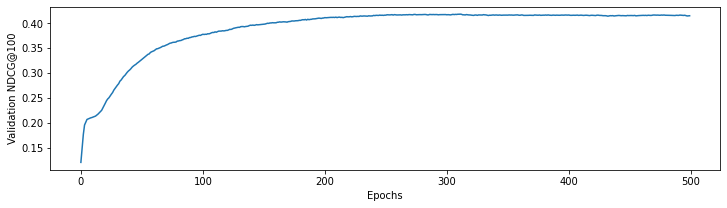

In [ ]:
print(appr.best_anneal)
plt.figure(figsize=(12, 3))
plt.plot(appr.ndcgs_vad)
plt.ylabel("Validation NDCG@"+str(appr.k_ndcg))
plt.xlabel("Epochs")
pass

In [ ]:
print(pro_dir)
n100_list, n10_list, r10_list, r20_list, r50_list = appr.test(test_data_tr, test_data_te)
print("Test NDCG@100=  {:.5f} (+-{:.5f})".format(np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test NDCG@10=  {:.5f} (+-{:.5f})".format(np.mean(n10_list), np.std(n10_list) / np.sqrt(len(n10_list))))
print("Test Recall@10= {:.5f} (+-{:.5f})".format(np.mean(r10_list), np.std(r20_list) / np.sqrt(len(r10_list))))
print("Test Recall@20= {:.5f} (+-{:.5f})".format(np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50= {:.5f} (+-{:.5f})".format(np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

ml-1m/pro_sg
Test NDCG@100=  0.42329 (+-0.00805)
Test NDCG@10=  0.32039 (+-0.01017)
Test Recall@10= 0.31570 (+-0.00914)
Test Recall@20= 0.35124 (+-0.00914)
Test Recall@50= 0.48465 (+-0.01004)


In [ ]:
print(pro_dir)
n100_list, n10_list, r10_list, r20_list, r50_list = appr.test(test_data_tr, test_data_te)
print("Test NDCG@100=  {:.5f} (+-{:.5f})".format(np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test NDCG@10=  {:.5f} (+-{:.5f})".format(np.mean(n10_list), np.std(n10_list) / np.sqrt(len(n10_list))))
print("Test Recall@10= {:.5f} (+-{:.5f})".format(np.mean(r10_list), np.std(r20_list) / np.sqrt(len(r10_list))))
print("Test Recall@20= {:.5f} (+-{:.5f})".format(np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50= {:.5f} (+-{:.5f})".format(np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

ml-1m/pro_sg
Test NDCG@100=  0.40950 (+-0.00786)
Test NDCG@10=  0.30763 (+-0.00969)
Test Recall@10= 0.30547 (+-0.00892)
Test Recall@20= 0.34155 (+-0.00892)
Test Recall@50= 0.46969 (+-0.01036)


### MultiDAE

In [ ]:
appr.train(train_data, vad_data_tr, vad_data_te)

TRAINING...
 Epoch   1, time= 29.7s/ 17.1s | Valid: ndcg_valid= 0.270% | *
 Epoch   2, time= 29.3s/ 16.6s | Valid: ndcg_valid= 0.332% | *
 Epoch   3, time= 29.2s/ 16.6s | Valid: ndcg_valid= 0.359% | *
 Epoch   4, time= 29.3s/ 16.4s | Valid: ndcg_valid= 0.375% | *
 Epoch   5, time= 29.1s/ 16.4s | Valid: ndcg_valid= 0.388% | *
 Epoch   6, time= 29.4s/ 16.4s | Valid: ndcg_valid= 0.397% | *
 Epoch   7, time= 29.5s/ 16.2s | Valid: ndcg_valid= 0.403% | *
 Epoch   8, time= 29.7s/ 16.2s | Valid: ndcg_valid= 0.407% | *
 Epoch   9, time= 29.4s/ 16.2s | Valid: ndcg_valid= 0.410% | *
 Epoch  10, time= 29.3s/ 16.4s | Valid: ndcg_valid= 0.413% | *
 Epoch  11, time= 29.3s/ 16.1s | Valid: ndcg_valid= 0.415% | *
 Epoch  12, time= 29.4s/ 16.3s | Valid: ndcg_valid= 0.416% | *
 Epoch  13, time= 29.5s/ 16.2s | Valid: ndcg_valid= 0.418% | *
 Epoch  14, time= 29.4s/ 16.4s | Valid: ndcg_valid= 0.419% | *
 Epoch  15, time= 29.3s/ 16.3s | Valid: ndcg_valid= 0.419% | *
 Epoch  16, time= 29.4s/ 16.3s | Valid: ndc

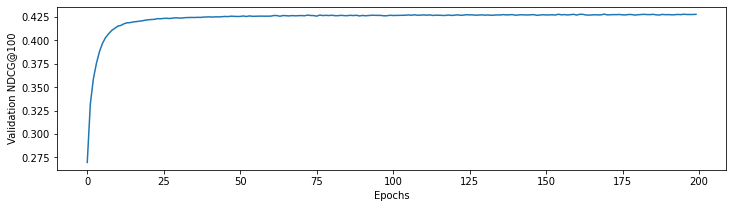

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(appr.ndcgs_vad)
plt.ylabel("Validation NDCG@"+str(appr.k_ndcg))
plt.xlabel("Epochs")
pass

In [ ]:
n100_list, n10_list, r10_list, r20_list, r50_list = appr.test(test_data_tr, test_data_te)
print("Test NDCG@100=  {:.5f} (+-{:.5f})".format(np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test NDCG@10=  {:.5f} (+-{:.5f})".format(np.mean(n10_list), np.std(n10_list) / np.sqrt(len(n10_list))))
print("Test Recall@10= {:.5f} (+-{:.5f})".format(np.mean(r10_list), np.std(r10_list) / np.sqrt(len(r10_list))))
print("Test Recall@20= {:.5f} (+-{:.5f})".format(np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50= {:.5f} (+-{:.5f})".format(np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=  0.43102 (+-0.00171)
Test NDCG@10=  0.33013 (+-0.00200)
Test Recall@10= 0.33491 (+-0.00204)
Test Recall@20= 0.39003 (+-0.00211)
Test Recall@50= 0.52367 (+-0.00225)
